# GPT-2 Fine-Tuning Tutorial with PyTorch & Huggingface in Colab




This is a simplified script for fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch.

You should understand the basics of PyTorch and how a training loop works before getting started. [This official PyTorch tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) serves as an excellent introduction. Familiarity with the workings of GPT2 might be useful but isn't required. The code has been written for clarity and not re-use. I'd advise refactoring it for actual projects. I've liberally taken bits from [Chris McCormick's BERT fine-tuning tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/), [Ian Porter's GPT2 tutorial](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html) and the [Hugging Face Language model fine-tuning script](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) so full credit to them. Chris' code has pretty much provided the basis for this script - you should definitely check out his [blog](https://mccormickml.com/tutorials/).

I should mention what the script doesn't cover:

- Using the [nlp](https://huggingface.co/nlp/) library to load in the dataset and setting up the training workflow, which looks to streamline things rather nicely.
- [Accumulated gradients](https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255) - this gives larger effective batch sizes than Colab allows (GPT2 is a large model, and anything more than a batch size of 2 would be enough to get a CUDA out of memory error on Colab).
- [Freezing layers](https://github.com/huggingface/transformers/issues/1431). This is the process of only changing the parameters in selected layers, made famous by the [ULMFit](https://arxiv.org/abs/1801.06146) process.
- [Using 'past'](https://huggingface.co/transformers/quickstart.html#using-the-past) when generating text. This takes in the previous state when generating successive items of text. I didn't need it.
- [Tensor packing](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html). This is a neat way of fitting in as much training data in each batch.
- [Hyperparameter search](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10). I settled quickly on values that seemed to produce decent values, without checking if they were optimal.

# Setup

In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.4 MB/s eta 0:00:00


In [2]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
!nvidia-smi

Fri Nov  3 03:38:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Create Training Set


In [4]:
# Upload data to Colab
from google.colab import files

csv_file = files.upload()

Saving plays.csv to plays.csv


In [5]:
# load into a data frame
df = pd.read_csv ('plays.csv')
df

,Play,Line
0,A Comedy of Errors,OCTAVIUS CAESAR: ACT I\nOCTAVIUS CAESAR: SCENE...
1,A Midsummer nights dream,FORD: ACT I\nFORD: SCENE I. Athens. The palace...
2,A Winters Tale,VALENTINE: ACT I\nVALENTINE: SCENE I. Antecham...
3,Alls well that ends well,KING EDWARD IV: ACT I\nKING EDWARD IV: SCENE I...
4,Antony and Cleopatra,ROSALIND: ACT I\nROSALIND: SCENE I. Alexandria...
5,As you like it,KING: ACT I\nKING: SCENE I. Orchard of Oliver'...
6,Coriolanus,DROMIO OF EPHESUS: ACT I\nDROMIO OF EPHESUS: S...
7,Cymbeline,AUFIDIUS: ACT I\nAUFIDIUS: SCENE I. Britain. T...
8,Hamlet,CYMBELINE: ACT I\nCYMBELINE: SCENE I. Elsinore...
9,Henry IV,nan\nnan\nnan\nKING HENRY IV: So shaken as we ...


In [6]:
df = df[['Line']]
df.dropna(inplace=True) #remove NA values
plays = df.Line.copy() #just use the main bio text in this example
plays

<ipython-input-6-1bbdc948b211>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True) #remove NA values


0     OCTAVIUS CAESAR: ACT I\nOCTAVIUS CAESAR: SCENE...
1     FORD: ACT I\nFORD: SCENE I. Athens. The palace...
2     VALENTINE: ACT I\nVALENTINE: SCENE I. Antecham...
3     KING EDWARD IV: ACT I\nKING EDWARD IV: SCENE I...
4     ROSALIND: ACT I\nROSALIND: SCENE I. Alexandria...
5     KING: ACT I\nKING: SCENE I. Orchard of Oliver'...
6     DROMIO OF EPHESUS: ACT I\nDROMIO OF EPHESUS: S...
7     AUFIDIUS: ACT I\nAUFIDIUS: SCENE I. Britain. T...
8     CYMBELINE: ACT I\nCYMBELINE: SCENE I. Elsinore...
9     nan\nnan\nnan\nKING HENRY IV: So shaken as we ...
10    PRINCE FORTINBRAS: ACT I\nPRINCE FORTINBRAS: P...
11    KING HENRY IV: ACT I\nKING HENRY IV: SCENE I. ...
12    SUFFOLK: ACT I\nSUFFOLK: SCENE I. London. The ...
13    WARWICK: ACT I\nWARWICK: SCENE I. London. The ...
14    Chorus: ACT I\nChorus: PROLOGUE\nChorus: I com...
15    BASTARD: ACT I\nBASTARD: SCENE I. Rome. A stre...
16    KING HENRY VIII: ACT I\nKING HENRY VIII: SCENE...
17    OCTAVIUS: ACT I\nOCTAVIUS: SCENE I. King L

We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

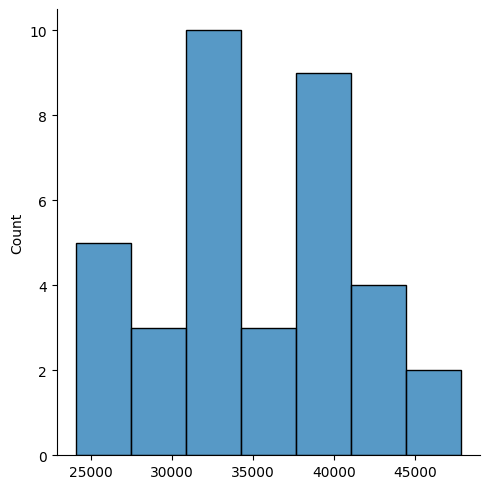

In [7]:
doc_lengths = []

for play in plays:

    # get rough token count distribution
    tokens = nltk.word_tokenize(play)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.displot(doc_lengths)

In [8]:
# the max token length
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

1.0

In [9]:
np.average(doc_lengths)

35070.916666666664

In [10]:
import re
from itertools import chain
def split_strings(string, token_size):
    """Splits a list of strings into sublists of the given size.

    Args:
    strings: A list of strings.
    token_size: The size of the sublists.

    Returns:
    A list of sublists of strings.
    """

    sublists = []
    words = string.split(" ")
    sublists = [" ".join(words[i:i+token_size]) for i in range(0, len(words), token_size)]
    return sublists

final = []
for play in plays:
    sublists = split_strings(play, 768)
    final.append(sublists)
len(sublists)

24

In [11]:
merged_list = list(chain(*final))

len(merged_list)

1123

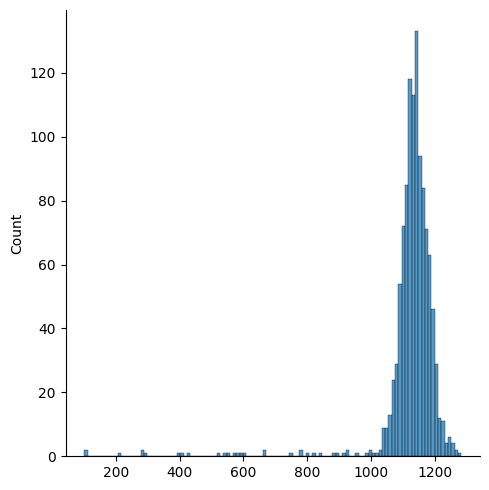

In [12]:
doc_lengths = []

for play in merged_list:

    # get rough token count distribution
    tokens = nltk.word_tokenize(play)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.displot(doc_lengths)

In [13]:
# the max token length
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.9830810329474622

In [14]:
np.average(doc_lengths)

1124.2680320569903

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens.

In [15]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


In [16]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [17]:
batch_size = 2

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [18]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each bio in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens.

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [19]:
dataset = GPT2Dataset(merged_list, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,010 training samples
  113 validation samples


In [20]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [21]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [22]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [23]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [25]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [26]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(  b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50,
                                    max_length = 200,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
#                            token_type_ids=None,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    505. Loss: 3.349668264389038.   Elapsed: 0:00:48.
0:  bipartisan, Trump has given them a first, but now the most.

First, Trump is now a Trump.
First, Trump is now a Trump.
First, Trump is now a Trump.
First, Trump is now a Trump.
First, Trump, his a fellow
First, Trump, and his a fellow, his friends
First, Trump, his friends, are the most, and I know how to keep them.
First, Trump, my man, my lady, and my lady,
First, Trump, my friend
First, Trump, my friend, and my friend
First, Trump, my friend and my friend
First, Trump, my friend, and the
First, Trump, my friend,
First, Trump, my friend, and the
First, Trump, and the
First, Trump, and the two, and their friends
First, Trump, my friend, and the
First, Trump,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    505. Loss: 3.470355272293091.   Elapsed: 0:01:43.
0:  increasing

First to the heavens and heavens from thee. If thou hast no eyes and eye-blows and no heart,
 sun is more angry than thyself. And
Dealing is more dangerous than your arms. Thou hast never had nor ever had
SOLO, nor have
Second. For thou dost doth bear
First, as the sun:
First. And thus the earth doth bear witness,
First. With the sun so near, no matter what it stands,
Second. Wherefore thy father thy young
First, hath given thee birth?
First. For thou dost, as the sun
First: Hath not a light for thy eyes?
Second. Shall not
First. Be a shepherd's sheep with
Second. A shepherd's sheep?
First. As one sheep, who hath no sheep
Second. To his own house, the mother-in-law,
Second. Has given thee her daughter


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    505. Loss: 3.3838260173797607.   Elapsed: 0:02:40.
0: day" word of the Lord.
But for he that is wise,
Thus, if it be so and I have it,
Won't it be so? If I do, what shall I, 'tis this? I know not,
Won't I be so? That may be the devil's fault in me
Won't I be so? Or for that I will be.
BENEATH ACT II
WANDENWICK I do not do thee a thing,
WANDENWICK I do not do thee a thing.
FRAGENWICK I will do thee this.
ANTISTRAN: You cannot leave me, or else,
ANTISTRAN: Here, what shall I do? If thou were a father, and thy daughter had to be killed,
ANTISTRAN: Now, what hast thou done,
ANTISTRAN: Of your husband's wife?
ANTISTR


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    505. Loss: 2.917548894882202.   Elapsed: 0:03:35.
0:  Hangthe of thine own, which is the only remedy for his sickness,
KING HENRY WATERS: And thou dost the better.
KING HENRY WATERS: Exit
CORNWALLING: My lord, this is an old matter:
CORNWALLING: Thou'll pardon mine sins and I can.
DUKE WATERS: Enter SCENE IV
CORNWALLING: This is a good place.
DUKE WATERS: Exit
SELLING: Exit
MARIOLE: The place is in it!
MARIOLE: The room is full of rich people.
SELLING: Exit
MARIOLE: And the king of France's palace!
MARIOLE: I know there you are, so long I have seen thee.
MARIOLE: So long as thou livest,
MARIOLE: I will see thee to be the duke.
MAR


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    505. Loss: 3.1638503074645996.   Elapsed: 0:04:30.
0:  foods to earth.
CRESSY: For as many as I know, that love betimes, and shall love both, and have to follow their love: but a single one that, when he's dead, shall be dead. I am dead.
CLARENCE: Let it be so, sir.
CLARENCE: And what's mine shall be.
CLARENCE: I have done many things wrong,
CLARENCE: But have kept myself with the old time.
CLARENCE: You are not dead, or shall be dead, for, sir,
CLARENCE: You are living in a house of comfort
CLARENCE: Like to see, and you are dead.
CLARENCE: O, my love, be not gone.
ClARENCE: Be well.
CARDINAL: A brother, cousin
CARDINAL: And be well, but now to-morrow we shall die.


  Average training loss: 4.66
  Training epoch took: 0:04:35

Running Validation...
  Validation Loss: 2.80
  Validation took: 0:00:10

======== Epoch 2 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    505. Loss: 2.694692850112915.   Elapsed: 0:00:54.
0:  trailhe's dead:
BUCKING: There is a woman in me,
BUCKING: The mother of men, as she comes from a man's eyes,
BUCKING: How shall she love him? 'Twere my lord of York,
BUCKING: Will she go about her own country,
BUCKING: And fetch, and drink, and live,
BUCKING: That he will like her more than himself.
BUCKING: No, my lord: for my lord, all he has,
BUCKING: Is nothing but the old lady
BUCKING: Of whom he loves most: and he sleeps by her
BUCKING: For love.
HAMLET: If there be aught that I know,
HAMLET: It shall be that he may go about his own country:
HAMLET: And, therefore, being born to hear me speak in my chamber,
HAMLET:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    505. Loss: 3.020630121231079.   Elapsed: 0:01:49.
0: intendin your heart!
First Soldier: Come hither, to the place of peace. I thank you.
First Soldier: My master,
First Soldier: hath made great haste to see you here,
First Soldier: with the rest of the people.
Third Soldier: Exit
Third Soldier: Good lord, what a good thing did this man
Third Soldier: did me: so grossly to leave
Third Soldier: him behind him when, in the meantime, I was sent,
Third Soldier: to fetch him the other soldiers at some place of good-conduct
Third Soldier: the night before.
Third Soldier: Exeunt
Third Soldier: Prithee! come hither to this place.
Third Soldier: Enter two Citizens, sir, and two Soldiers
Second Soldier: What news?
Third Soldier: This town hath been lost of the people.
Second Soldier: Come hither, to seek the people for the body.
Third Soldier: Enter A


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    505. Loss: 2.6964058876037598.   Elapsed: 0:02:45.
0:  surroundis his,
KING CLAUDIUS: O, I will hear him not,
KING CLAUDIUS: So he hath no excuse.
LUCIANA: What do you say to the boy?
KING CLAUDIUS: 'Tis the good and comfort of his life
KING CLAUDIUS: You hear me say, 'This's too late to marry a man.'
KING CLAUDIUS: 'Tis very likely that I will.
KING CLAUDIUS: But be not so certain: it shall be more than a match.
KING CLAUDIUS: You shall hear him talk, I do.
KING CLAUDIUS: Exeunt
KING CLAUDIUS: SCENE I. Before the door of the house.
KING CLAUDIUS: Enter PROSPER
PROSPER: O, this is too late.
KING CLAUDIUS: Welcome hither, sir


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    505. Loss: 2.5249969959259033.   Elapsed: 0:03:41.
0:  reflexman,
MORONIO DEANO: The enemy shall be ready to strike,
MORONIO DEANO: The enemy shall be near.
VIOLA: A great navy
VIOLA: With such an arm'd bulk as the Greeks have.
VIOLA: To strike, the Greeks have a better ship.
VIOLA: The Greeks do, the Greeks sink.
VIOLA: Now to fight, the enemy:
VIOLA: No more.
VIOLA: The Greeks do not.
VIOLA: The enemy is at hand.
VIOLA: Enter CARDINAL BOWL
LORENZO: Now, ho, a trumpet calls!
CHARMIANIO DEANO: Enter CARDINAL BOWL
LORENZO: There, ho! ho! ho!
CHARMIANIO DEANO: Now that you had not been wounded


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    505. Loss: 2.7945265769958496.   Elapsed: 0:04:36.
0:  display of her love and service, but the same is no more.
MISTRESS CLAUDIUS: I was told the prince, in spite of the truth, told me the prince had deceived me.
MISTRESS CLAUDIUS: I was a friend of the prince, but now I have been a friend of him too,
MISTRESS CLAUDIUS: But all is love and not hate, that I am in love with him.
MISTRESS CLAUDIUS: O, let him have a bridegroom, and let this be thy bed.
MISTRESS CLAUDIUS: To this I say he should:
MISTRESS CLAUDIUS: He cannot keep one, or I am for him.
MISTRESS CLAUDIUS: But, gentle Margaret, you are well known by our house.
MISTRESS CLAUDIUS: I thank your

  Average training loss: 2.75
  Training epoch took: 0:04:41

Running Validation...
  Validation Loss: 2.70
  Validation took: 0:00:10

======== Epoch 3 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    505. Loss: 2.4595189094543457.   Elapsed: 0:00:54.
0:  pastorthinks
THERSITES: Which, even to this hour and a half in thine eye,
THERSITES: Can make this house laugh at thy name,
THERSITES: And bring forth a greater part of thy grace,
THERSITES: Which I know, I swear to you, I cannot tell you:
THERSITES: But, if thou wouldst believe in the name of my father,
THERSITES: I would take thy hand and bring thee to a place of love.
First Lord: O Lord,
First Lord: For that thou art my father, I think thy father
First Lord: He's a very noble lord, he's the son of a very virtuous
First Lord: And, indeed, I am a very good man.
First Lord: Exeunt
First Lord: SCENE II. Another room in the same house.
First Lord: Enter TIMORA


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    505. Loss: 2.375549793243408.   Elapsed: 0:01:49.
0:  illicithats.
MILFORD: Alas, your speech does hurt a woman.
PANDARUS: But, good cousin,--
MILFORD: Your speech is like weeping:
MILFORD: Your tears do hurt me
MILFORD: And this does effect my love:
MILFORD: 'Tis but this speech that has a lasting effect.
PANDARUS: Ay, good cousin, but what should you say?
MILFORD: I'll tell you,
MILFORD: It has a great effect of good reason,
MILFORD: But it's very bitter:--
PANDARUS: Wherefore did you mean what thou wast made of?
PANDARUS: Because I had rather be made
PANDARUS: Of some very unhappy substance.
PRINCE HENRY: What, you speak in this way, good cousin


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    505. Loss: 2.2535526752471924.   Elapsed: 0:02:45.
0:  Liberationin a most excellent manner
LAERTES: Of the people and their estates and the world.
LAERTES: We may not say so.
LAERTES: Exeunt
LAERTES: SCENE I. The same. OLIVIA's house.
LAERTES: Enter PISTOL, and EDGAR
OLIVIA: Here comes OLIVIA, a very ancient
OLIVIA: man, and most venerable knight: he is our heir,
OLIVIA: And will give us life in this land.
IAGO: He's a worthy father, and I am sworn.
OLIVIA: I pray God for him!
IAGO: Let our love guide it, as if we could take him
IAGO: By fortune's eye.
OLIVIA: Here comes a very brave OLIVIA:
OLIVIA: And, in the shape of a very noble man,
OL


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    505. Loss: 2.398305654525757.   Elapsed: 0:03:41.
0:  NamBADFORD: Come, boy! come, sir, and tell him what you mean: I will send your ladyship on his errand,
DUKE EDWARD: And then, sir, go with him on our journey.
BARDOLPH: He is coming, sir: but the lady shall be a guest:
BARDOLPH: Go away with him, sir, away with me, away with her.
DUKE EDWARD: I was a guest on your journey, sir.
BARDOLPH: I had not such a companion as she
BARDOLPH: Hath, in her very heart, been.
DUKE EDWARD: Why should I go, boy?
DUKE EDWARD: Why should I go, sir?
BARDOLPH: Exeunt
BARDOLPH: SCENE II. A street in the town.
BARDOLPH: Enter GL


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    505. Loss: 2.4118380546569824.   Elapsed: 0:04:38.
0: IONDUKE OF BOLINGBROKE: SCENE V. A room in KING JOHN'S palace.
KING JOHN: Enter BALTHAS
KING JOHN: Here you are all set together in peace, my liege. The French were great in France,
KING JOHN: And, after I had said so much, they came all to make peace.
KING JOHN: They met me there, my liege, and took me as prisoner,
KING JOHN: And, after that, 'tis so, for the good we both do,
KING JOHN: And so, what's your grace, I fear, shall return again,
KING JOHN: For this, my liege, was my last offence.
KING JOHN: But, I know my son hath not done any offence,
KING JOHN: So, be it known, 'tis a shame, and, as a gentleman
KING JOHN: You knew him as you have, the king

  Average training loss: 2.57
  Training epoch took: 0:04:43

Running Validation...
  Validation Loss: 2.67
  Validation took: 0:00:10

======== Epoch 4 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    505. Loss: 2.286072254180908.   Elapsed: 0:00:54.
0:  glimpseup with
HASTINGS: a canopy of roses and thorns, as she
HASTINGS: stands in such a nest of blood-colours
HASTINGS: That e'er you can hear her roar within
HASTINGS: the eye, and make them shake in a frenzy
HASTINGS: Of sudden motion, like a raging lion, or a
HASTINGS: horse, or any such thing.
HASTINGS: She is, indeed, very ill, and her spirits fly
HASTINGS: out and run her through the air with such a fury
HASTINGS: That if you speak her a word,
HASTINGS: I will fly by her and let her sing. She sings
HASTINGS: Like a harp in his sleep, and will die the death
HASTINGS: Which's past his prime.
HASTINGS: Enter a Messenger
Messenger: Messenger! a messenger


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    505. Loss: 2.451751232147217.   Elapsed: 0:01:50.
0:  Laurein me! and I, as thou art,
HUBERT: My sweet sister and my dear Beatrice: if your love
HUBERT: Can give my poor Juliet and I, I shall not
HUBERT: Give him any thing for my love, which I hope he shall
HUBERT: Afford and enjoy with his love.
HORTENSIO: Nay, my sweet Juliet, this hour you are dead,
HORTENSIO: Before the law can pardon him.
HORTENSIO: Exit HORTENSIO
HORTENSIO: ACT III
HORTENSIO: SCENE I. Florence. A street.
HORTENSIO: Enter BARDOLPH
BARDOLPH: Why dost thou bid me enter into Florence?
BARDOLPH: Good madam, sir, I am come from my wife.
BARDOLPH: I have but lately come from my husband


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    505. Loss: 2.188305377960205.   Elapsed: 0:02:46.
0: ismto his death.
BRUTUS: You would do me but shame me, Brutus,
BRUTUS: And tell me I am a knave: what are you and your brother?
ROSALINE: You, sir, and your mistress,
ROSALINE: Which in the name of honour must be respected
ROSALINE: By you and my state and honour: I have been framed
ROSALINE: In honourable apparel,
ROSALINE: That I can neither have nor lose:
ROSALINE: For if you have not a good conscience,
ROSALINE: You are so weak, and your master,
ROSALINE: That you have disgraced yourself by you making
ROSALINE: You a subject, that 'tis not worth your time
ROSALINE: To tell the whole tale further.
BRUTUS: Then pardon me, if you


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    505. Loss: 2.544175624847412.   Elapsed: 0:03:42.
0: ounhut!
KATHARINA: I do believe your majesty should not so easily flatter me with such unacquainted
KATHARINA: behaviors as mine eyes, which cannot be as great
KATHARINA: as yours.
KATHARINA: What, Sir Andrew, is the matter with you?
KATHARINA: Well, I will not say with myself, but to you.
KING JOHN: Nay, give me such letters of your own with good
KING JOHN: purpose, the better for it: but, by the
KING JOHN: more honest mean, I shall not choose this place for myself
KING JOHN: to trust you: if I will say so, I'll do it with a good heart.
KATHARINA: It will fit you well,
KATHARINA: You are altogether right, and I do trust them highly,
KATHARINA: And what of you is good?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    505. Loss: 2.3665101528167725.   Elapsed: 0:04:37.
0:  electionheaven, and
ADRIANA: the sun hath not seen thee,
ADRIANA: That ever saw thee shine before thee. I had been more
ADRIANA: weary than thou wast,
ADRIANA: And yet I came not nearer thy sight,
ADRIANA: Nor came more nearer thee then I am. But I am gone,
ADRIANA: Till I come to the Capitol, which, I must confess,
ADRIANA: Stands here in the east.
FLORIZEL: And yet here's my lord,
FLORIZEL: That, in truth, I'll not be satisfied with
FLORIZEL: The present business, as, as he is at point,
FLORIZEL: He hath made me promise to pay.
PAGE: No,
PAGE: My liege shall be satisfied with your present.
PAGE: Exit BORACHIO
PA

  Average training loss: 2.44
  Training epoch took: 0:04:42

Running Validation...
  Validation Loss: 2.66
  Validation took: 0:00:10

======== Epoch 5 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    505. Loss: 2.2808165550231934.   Elapsed: 0:00:54.
0:  crazyI will not be sworn, for I have no fear of perjury.
BORACHIO: How now,
BORACHIO: That you did not think there was such a god?
ROSALIND: It is an honour that men do not honour,
ROSALIND: As a great fool that cannot be sworn to do such things.
BRUTUS: We will put it away: 'tis strange
BRUTUS: To think that we could be sworn.
BRUTUS: Here's the other gentleman in the same case,
BRUTUS: Who was a man at first disgraced:
BRUTUS: And now let him go. Now, sir,
BRUTUS: How can I live a lie?
CASSIO: 'Twas true, indeed,
CASSIO: And yet my lord the pope is a man and
CASSIO: A very cardinal, but yet not a cardinal


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    505. Loss: 2.4027020931243896.   Elapsed: 0:01:50.
0:  benchI am glad, sir.
IMOGEN: That there might be some mischief in't, as you are:
IMOGEN: Not in all the same sort: this is the very quarrel
IMOGEN: Let us in, good sir.
IMOGEN: It shall be well known.
IMOGEN: You must not come into my chamber, sir,
IMOGEN: I will bring them no harm.
IMOGEN: My father hath a son of mine: he's a bachelor.
IMOGEN: Exit
IMOGEN: ACT IV
IMOGEN: SCENE I. The same.
IMOGEN: Enter the DUKE, ROSS, SOMERSET, and the rest of the DUKE train, at the gate
DUKE: Ah, here's a gentleman, sir.
DUKE: I told him that he and I were in the same hour.
DUKE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    505. Loss: 2.582059621810913.   Elapsed: 0:02:46.
0:  incorporatedthis?
KING EDWARD IV: Ay, or I will come seek him out at your pleasure.
KING EDWARD IV: How far shall I drive him back?
KING EDWARD IV: What will he seek to know you?
PRINCE HENRY: He shall hear your counsel, and tell of you.
KING EDWARD IV: And why didst thou not call the Count's brother
KING EDWARD IV: That brought you this?
KING EDWARD IV: What, what a plague upon your country!
KING EDWARD IV: What a sickness hath thou here!
KING EDWARD IV: Wherein thou wast slain?
PRINCE HENRY: In Denmark, the father that thou didst,
PRINCE HENRY: That I saw perform his unnatural
PRINCE HENRY: With the sword I had slain: I did not fear,
PRINCE HENRY: But did fear


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    505. Loss: 2.357560873031616.   Elapsed: 0:03:42.
0: Peters.
PISTOL: This is a most strange invention.
PISTOL: This is a gentleman named Frederick,
PISTOL: He was the son of Sir William C.
PISTOL: This is a gentleman called Clarence.
PISTOL: This is a gentleman born near Oxford,
PISTOL: And of the same name was the heir
PISTOL: Of the commonwealth to the realm.
PISTOL: Enter a Gentleman with a Garter
Gentleman: What mean you to call this prince Duke Frederick?
MARK ANTONY: By my troth, sir, I will not.
Gentleman: How now, madam?
MARK ANTONY: By my troth, I would he had such a name.
MARK ANTONY: By his troth, I do believe a very prince,
MARK ANTONY: No man dare be that name


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    505. Loss: 2.3248050212860107.   Elapsed: 0:04:38.
0: uringThe sun is not hid behind his side,
BASSETTA: Let me see his face, for I'll have another look.
BASSETTA: Flourish of cornets, muffled cheese and baked beans
BASSETTA: I'll have another look: but my very first look
BASSETTA: May I see the man now, for I will have another look,
BASSETTA: A second look till then, a third look till then.
BASSETTA: I'll go dress, if you will.
BASSETTA: Exeunt
BASSETTA: SCENE IV. Alexandria. A room in LEONTES' house.
BASSETTA: Enter LEONTES and MALCOLM
LEONTES: Here's a woman.
MALCOLM: What, she is a maid?
LEONTES: Mistress?
LEONTES: I am

  Average training loss: 2.34
  Training epoch took: 0:04:43

Running Validation...
  Validation Loss: 2.67
  Validation took: 0:00:10

Training complete!
Total training took 0:24:13 (h:mm:ss)


Let's view the summary of the training process.

In [27]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,4.658065,2.800564,0:04:35,0:00:10
2,2.746039,2.700119,0:04:41,0:00:10
3,2.569379,2.668676,0:04:43,0:00:10
4,2.436281,2.660774,0:04:42,0:00:10
5,2.336496,2.668233,0:04:43,0:00:10


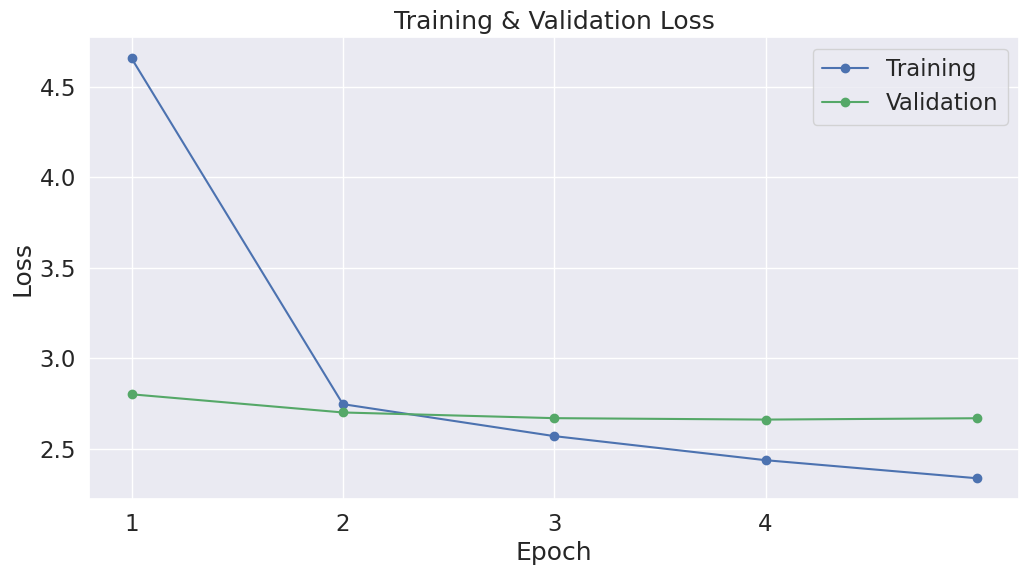

In [28]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [29]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Generate Text

In [33]:
model.eval()

prompt = "with a car you can go anywhere you want"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[4480,  257, 1097,  345,  460,  467, 6609,  345,  765]],
       device='cuda:0')
0: with a car you can go anywhere you want.'
GLOUCESTER: Now, uncle, if you cannot be seen,
GLOUCESTER: And so long live the day that day, yet, I have
GLOUCESTER: My candle and my pen and, lo, what's that to you?
GLOUCESTER: 'For fear I do not know what you are.'
GONERIL: How meanest a man?
GLOUCESTER: 'Tell me how I can live to see my lord's death.
GLOUCESTER: You should find the news abroad more easy
GLOUCESTER: Than look out for yourself abroad.'
GONERIL: Here's the letter of Henry Percy.
GONERIL: You know him well, your cousin is well.
GLOUCESTER: 'An English man, I know, and he is well beloved.
GLOUCESTER: But, uncle, I cannot go to him for aught:
GLOUCESTER: Where is your friend?
GLOUCESTER: There, uncle, where is my lord that died.
GLOUCESTER: Go, and bid him go to me: he's a gentleman, he's
GLOUCESTER: Of noble birth, not of bad reputation,
GLOUCESTER: And with all due


1: with a car you c

These aren't bad at all!
